In [1]:
# !pip install timm transformers

In [2]:
# !pip install torchtext==0.8.0
# !pip install torch==1.8.1 torchvision==0.9.1

In [3]:
# !pip install transformers -U

In [1]:
import torch
from PIL import Image
import requests
import torchvision.transforms as T
import matplotlib.pyplot as plt
from collections import defaultdict
import torch.nn.functional as F
import numpy as np
from skimage.measure import find_contours

from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import seaborn as sns
import pandas as pd
import glob
import json
torch.set_grad_enabled(False);

In [2]:
torch.__version__

'1.8.1+cu102'

In [3]:
def load_data(N, mode='train'):
    with open(f'clevr/CLEVR_v1/questions/CLEVR_{mode}_questions.json') as f:
        data = json.load(f)
        data_set_size = len(data['questions'])
        records = []
        for k in np.random.uniform(0, data_set_size, N).astype(int):
            i = data['questions'][k]
            temp=[]
            for path in glob.glob(f'clevr/CLEVR_v1/images/{mode}/'+i['image_filename']): 
                temp.append(path)
            temp.append(i['question'])
            temp.append(i['answer'])
            records.append(temp)
    labels=['Path','Question','Answer']
    return pd.DataFrame.from_records(records, columns=labels)

In [24]:
train_df = load_data(5000, 'train')
val_df = load_data(1000, 'val')

In [5]:
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [6]:
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def plot_results(pil_img, scores, boxes, labels, masks=None):
    plt.figure(figsize=(16,10))
    np_image = np.array(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if masks is None:
        masks = [None for _ in range(len(scores))]
    assert len(scores) == len(boxes) == len(labels) == len(masks)
    for s, (xmin, ymin, xmax, ymax), l, mask, c in zip(scores, boxes.tolist(), labels, masks, colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{l}: {s:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))
        if mask is None:
            continue
        np_image = apply_mask(np_image, mask, c)

        padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=c)
            ax.add_patch(p)


    plt.imshow(np_image)
    plt.axis('off')
    plt.show()


def add_res(results, ax, color='green'):
    if True:
        bboxes = results['boxes']
        labels = results['labels']
        scores = results['scores']    
    colors = ['purple', 'yellow', 'red', 'green', 'orange', 'pink']
    
    for i, (b, ll, ss) in enumerate(zip(bboxes, labels, scores)):
        ax.add_patch(plt.Rectangle((b[0], b[1]), b[2] - b[0], b[3] - b[1], fill=False, color=colors[i], linewidth=3))
        cls_name = ll if isinstance(ll,str) else CLASSES[ll]
        text = f'{cls_name}: {ss:.2f}'
        print(text)
        ax.text(b[0], b[1], text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))

In [7]:
model_qa = torch.hub.load('ashkamath/mdetr:main', 'mdetr_clevr', pretrained=True, return_postprocessor=False)
model_qa = model_qa.cuda()
model_qa.eval();

Using cache found in /home/student/.cache/torch/hub/ashkamath_mdetr_main
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


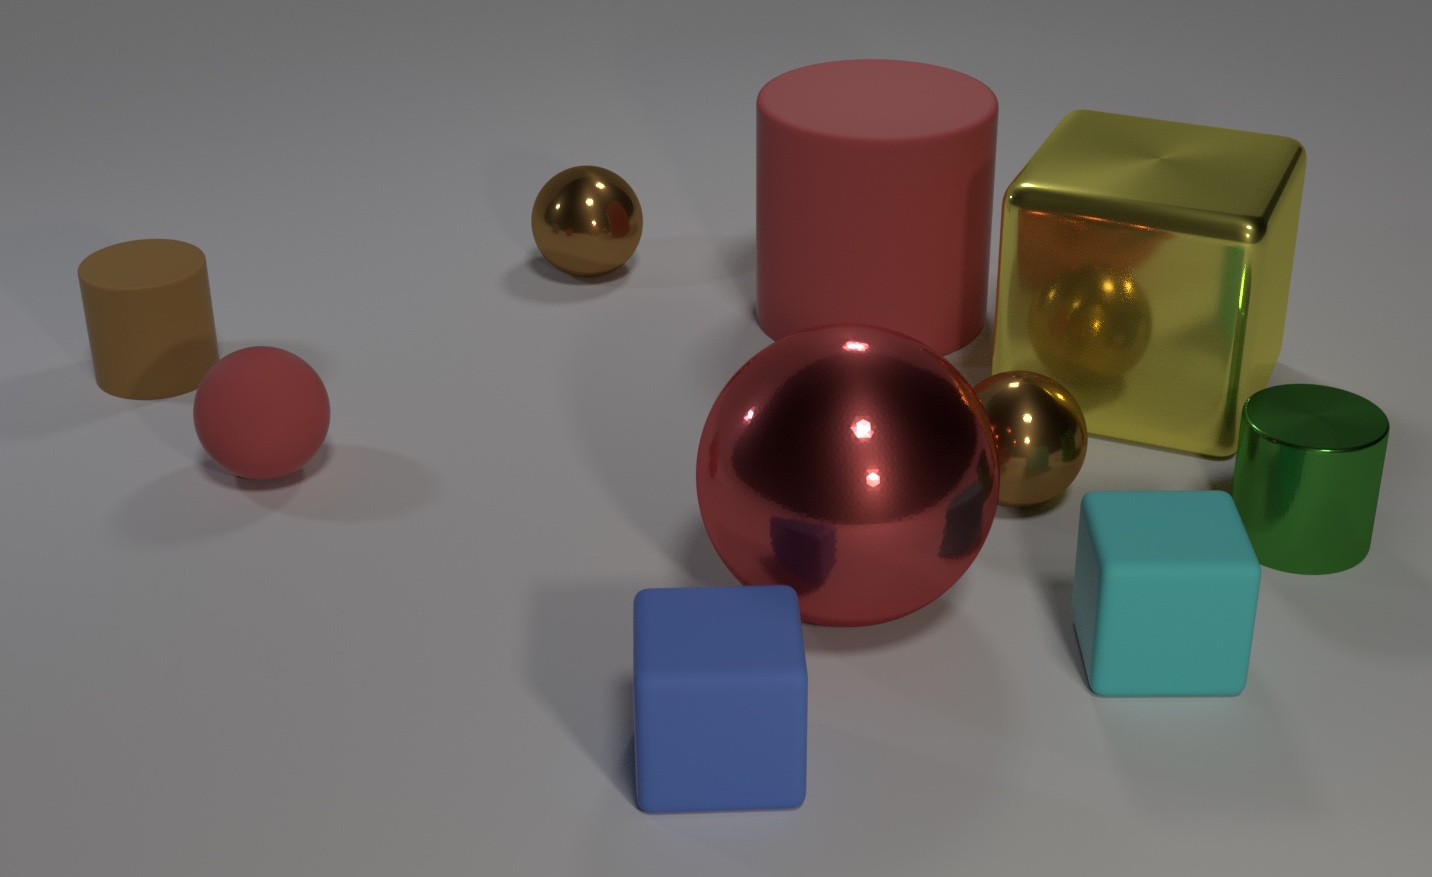

In [17]:
url = "https://cs.stanford.edu/people/jcjohns/clevr/teaser.jpg"
img = Image.open(requests.get(url, stream=True).raw)
img

In [19]:
ALL_ATTRIBUTES = [
    "small",
    "large",
    "gray",
    "red",
    "blue",
    "green",
    "brown",
    "purple",
    "cyan",
    "yellow",
    "cube",
    "sphere",
    "cylinder",
    "rubber",
    "metal",
]


def plot_inference_qa(im, caption):
    img = transform(im).unsqueeze(0).cuda()
    memory_cache = model_qa(img, [caption], encode_and_save=True)
    outputs = model_qa(img, [caption], encode_and_save=False, memory_cache=memory_cache)
    answers = []
    answer_types = outputs["pred_answer_type"].argmax(-1)
    answer_types = [x.item() for x in answer_types]
    for i, ans_type in enumerate(answer_types):
        if ans_type == 0:
            answers.append("yes" if outputs["pred_answer_binary"][i].sigmoid() > 0.5 else "no")
        elif ans_type == 1:
            answers.append(ALL_ATTRIBUTES[outputs["pred_answer_attr"][i].argmax(-1).item()])
        elif ans_type == 2:
            answers.append(str(outputs["pred_answer_reg"][i].argmax(-1).item()))
        else:
            assert False, "must be one of the answer types"

    res = [{"prediction": answer} for answer in answers]
    probas = 1 - outputs['pred_logits'].softmax(-1)[0, :, -1].cpu()
    keep = (probas > 0.7).cpu()
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'].cpu()[0, keep], im.size)
    positive_tokens = (outputs["pred_logits"].cpu()[0, keep].softmax(-1) > 0.1).nonzero().tolist()
    predicted_spans = defaultdict(str)
    for tok in positive_tokens:
        item, pos = tok
        if pos < 255:
            span = memory_cache["tokenized"].token_to_chars(0, pos)
            predicted_spans [item] += " " + caption[span.start:span.end]

    labels = [predicted_spans[k] for k in sorted(list(predicted_spans.keys()))]
    plot_results(im, probas[keep], bboxes_scaled, labels)
    print(caption)
    print(f"Predicted answer: {answers[0]}")

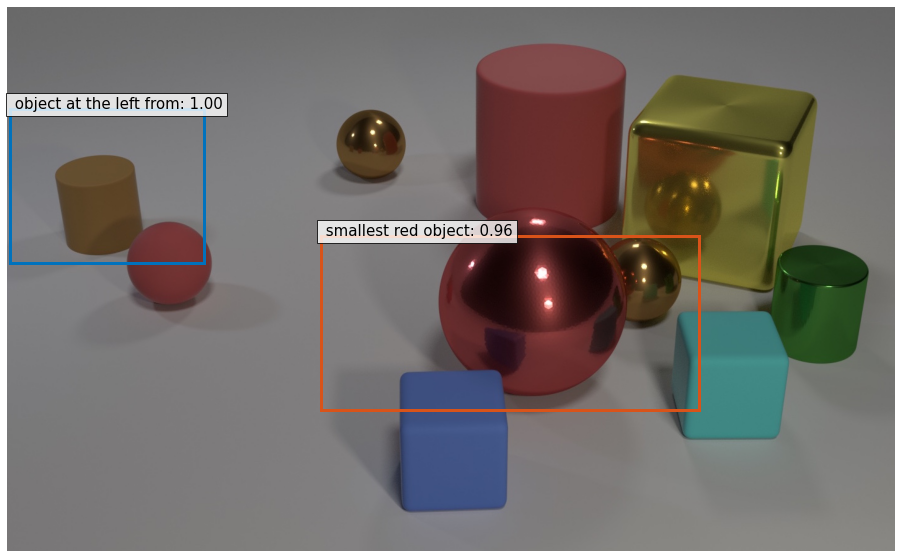

What material has the object at the left from the smallest red object?
Predicted answer: rubber


In [20]:
plot_inference_qa(img, "What material has the object at the left from the smallest red object?")

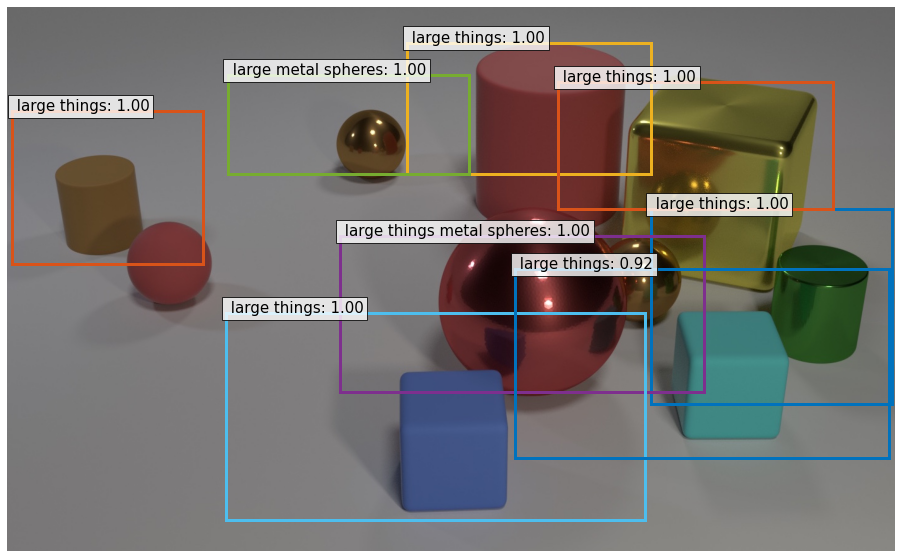

 Question: Are there an equal number of large things and metal spheres?
 Predicted answer: no


In [23]:
plot_inference_qa(img, "Are there an equal number of large things and metal spheres?")

In [22]:
def make_prediction(x):
    img_path, question = x[0], x[1]
    img = Image.open(img_path).convert('RGB')
    img = transform(img).unsqueeze(0).cuda()
    memory_cache = model_qa(img, [question], encode_and_save=True)
    outputs = model_qa(img, [question], encode_and_save=False, memory_cache=memory_cache)
    answers = []
    answer_types = outputs["pred_answer_type"].argmax(-1)
    answer_types = [x.item() for x in answer_types]
    for i, ans_type in enumerate(answer_types):
        if ans_type == 0:
            answers.append("yes" if outputs["pred_answer_binary"][i].sigmoid() > 0.5 else "no")
        elif ans_type == 1:
            answers.append(ALL_ATTRIBUTES[outputs["pred_answer_attr"][i].argmax(-1).item()])
        elif ans_type == 2:
            answers.append(str(outputs["pred_answer_reg"][i].argmax(-1).item()))
        else:
            assert False, "must be one of the answer types"
    return answers[0]

In [25]:
from tqdm.notebook import tqdm
tqdm.pandas()

val_df['predictions'] = val_df.progress_apply(make_prediction, axis=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [26]:
train_df['predictions'] = train_df.progress_apply(make_prediction, axis=1)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [27]:
val_df.head()

,Path,Question,Answer,predictions
0,clevr/CLEVR_v1/images/val/CLEVR_val_004688.png,How many objects are tiny matte objects that a...,6,2
1,clevr/CLEVR_v1/images/val/CLEVR_val_009907.png,Is the number of large things on the right sid...,no,no
2,clevr/CLEVR_v1/images/val/CLEVR_val_006449.png,How many other small purple things are the sam...,0,0
3,clevr/CLEVR_v1/images/val/CLEVR_val_003055.png,Is there a tiny purple object on the right sid...,yes,yes
4,clevr/CLEVR_v1/images/val/CLEVR_val_006260.png,Is the small shiny object the same color as th...,no,no


In [28]:
proability_val = (val_df[val_df['Answer'] == val_df['predictions']].count() / len(val_df))[0]
proability_val

0.83

In [29]:
proability_train = (train_df[train_df['Answer'] == train_df['predictions']].count() / len(train_df))[0]
proability_train

0.8496

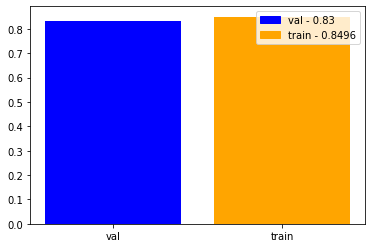

In [30]:
plt.bar(["val", "train"], [proability_val, proability_train], color=['b', 'orange'])
colors = {f'val - {proability_val}':'b', f'train - {proability_train}':'orange'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.show()

In [31]:
val_df['Answer'].unique(), val_df['predictions'].unique()

(array(['6', 'no', '0', 'yes', 'large', '1', 'cylinder', 'small', '2',
        'yellow', 'sphere', 'blue', 'cube', 'red', 'rubber', '3', 'cyan',
        'metal', 'green', 'brown', 'gray', 'purple', '7', '4', '5', '9'],
       dtype=object),
 array(['2', 'no', '0', 'yes', 'large', '1', 'cylinder', 'small', 'yellow',
        'sphere', 'blue', 'cube', 'red', 'rubber', 'cyan', 'metal',
        'green', 'brown', 'gray', 'purple', '3', '4', '5'], dtype=object))

In [32]:
corrMatrix = val_df[['Answer', 'predictions']].corr()

In [33]:
corrMatrix = pd.crosstab(val_df['Answer'], val_df['predictions'], normalize='index')
corrMatrix.columns

Index(['0', '1', '2', '3', '4', '5', 'blue', 'brown', 'cube', 'cyan',
       'cylinder', 'gray', 'green', 'large', 'metal', 'no', 'purple', 'red',
       'rubber', 'small', 'sphere', 'yellow', 'yes'],
      dtype='object', name='predictions')

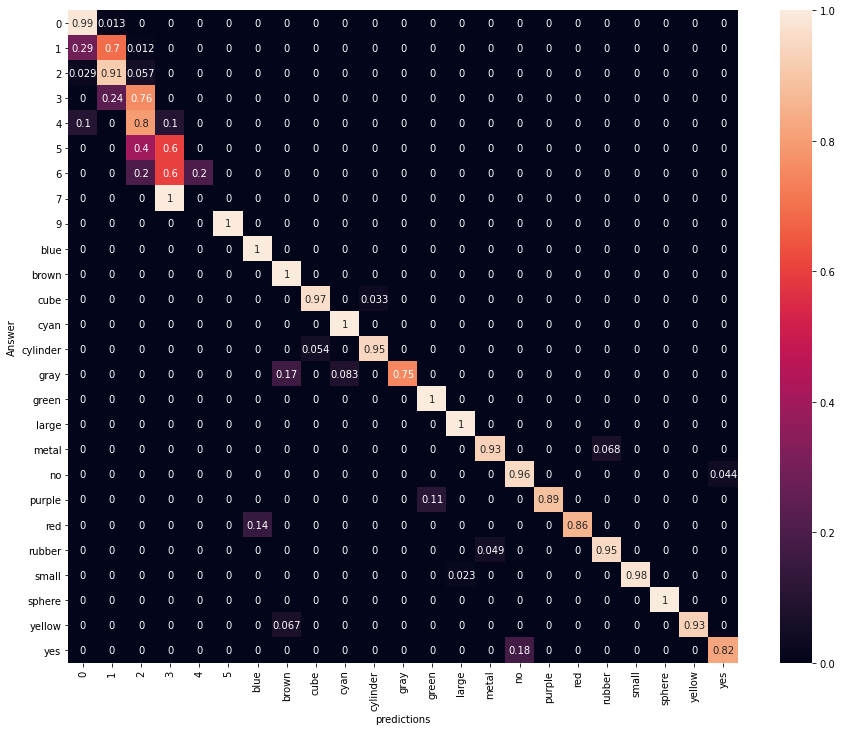

In [34]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(corrMatrix, annot=True, ax=ax)
plt.show()